# Multiobjective optimization with Pareto front mapping

One way to do multiobjective optimization is with Pareto optimization, which explores the set of Pareto-efficient points. A point is Pareto-efficient if there are no other valid points that are better at every objective: it shows the "trade-off" between several objectives. 

In [1]:
import datetime

from bluesky.callbacks import best_effort
from bluesky.callbacks.tiled_writer import TiledWriter
from bluesky.run_engine import RunEngine
from ophyd.utils import make_dir_tree  # Constants
from tiled.client import from_uri
from tiled.server import SimpleTiledServer

DEFAULT_ROOT_DIR = "/tmp/sirepo-bluesky-data"

tiled_server = SimpleTiledServer()
tiled_client = from_uri(tiled_server.uri)
tiled_writer = TiledWriter(tiled_client)


def setup_re_env(db_type="default", root_dir="/default/path"):
    RE = RunEngine({})
    bec = best_effort.BestEffortCallback()
    RE.subscribe(bec)
    RE.subscribe(tiled_writer)
    _ = make_dir_tree(datetime.datetime.now().year, base_path=root_dir)
    return {'RE': RE, 'tiled': tiled_client, 'bec': bec}


env = setup_re_env(db_type="temp", root_dir=DEFAULT_ROOT_DIR)
globals().update(env)

Tiled version 0.1.0b21.dev13+g2ac3a565


2025-04-02 09:40:00.977 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


In [2]:
import numpy as np

from blop import DOF, Agent, Objective


def digestion(df):
    for index, entry in df.iterrows():
        x1, x2 = entry.x1, entry.x2

        df.loc[index, "f1"] = (x1 - 2) ** 2 + (x2 - 1) + 2
        df.loc[index, "f2"] = 9 * x1 - (x2 - 1) + 2
        df.loc[index, "c1"] = x1**2 + x2**2
        df.loc[index, "c2"] = x1 - 3 * x2 + 10

    return df


dofs = [
    DOF(name="x1", search_domain=(-20, 20)),
    DOF(name="x2", search_domain=(-20, 20)),
]


objectives = [
    Objective(name="f1", target="min"),
    Objective(name="f2", target="min"),
    Objective(name="c1", constraint=(-np.inf, 225)),
    Objective(name="c2", constraint=(-np.inf, 0)),
]

agent = Agent(
    dofs=dofs,
    objectives=objectives,
    digestion=digestion,
    tiled=tiled,
)

(uid,) = RE(agent.learn("qr", n=64))

/home/jmoylan1/miniconda3/envs/test_tiled_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-02 09:39:58.958 INFO: Executing plan <generator object Agent.learn at 0x7394fcbc41d0>
2025-04-02 09:39:58.959 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x73951cdd3190> from 'idle' -> 'running'
2025-04-02 09:39:59.008 INFO: HTTP Request: POST http://127.0.0.1:37057/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-04-02 09:39:59.018 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:39:59.027 INFO: HTTP Request: POST http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3 "HTTP/1.1 200 OK"
2025-04-02 09:39:59.034 INFO: HTTP Request: POST http://127.0.0.1:37057/ap



Transient Scan ID: 1     Time: 2025-04-02 09:39:58
Persistent Unique Scan ID: '6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 09:39:59.1 |     -1.273 |     -4.030 |
|         2 | 09:39:59.1 |     -7.656 |     -1.946 |


2025-04-02 09:39:59.194 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:39:59.200 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:39:59.207 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:39:59.216 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:39:59.223 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:39:59.229 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8

|         3 | 09:39:59.2 |    -11.393 |     -0.408 |
|         4 | 09:39:59.2 |    -10.869 |      0.609 |
|         5 | 09:39:59.2 |     -9.626 |      2.039 |
|         6 | 09:39:59.2 |     -7.368 |      5.853 |
|         7 | 09:39:59.3 |     -0.821 |      3.859 |
|         8 | 09:39:59.3 |      3.069 |      4.465 |
|         9 | 09:39:59.3 |      0.175 |      8.268 |
|        10 | 09:39:59.4 |     -3.748 |      7.623 |


2025-04-02 09:39:59.416 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:39:59.422 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:39:59.429 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:39:59.435 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:39:59.440 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:39:59.446 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8

|        11 | 09:39:59.4 |     -5.757 |     10.921 |
|        12 | 09:39:59.4 |     -4.376 |     12.556 |
|        13 | 09:39:59.4 |      1.700 |     13.200 |
|        14 | 09:39:59.5 |      5.082 |     16.521 |
|        15 | 09:39:59.5 |      3.807 |     19.377 |
|        16 | 09:39:59.5 |     -2.305 |     18.771 |
|        17 | 09:39:59.5 |     -8.500 |     17.127 |
|        18 | 09:39:59.6 |    -12.256 |     15.540 |


2025-04-02 09:39:59.636 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:39:59.643 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:39:59.650 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:39:59.656 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:39:59.663 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:39:59.670 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e

|        19 | 09:39:59.6 |    -18.541 |     18.562 |
|        20 | 09:39:59.6 |    -15.640 |     14.797 |
|        21 | 09:39:59.6 |    -14.501 |     11.726 |
|        22 | 09:39:59.7 |    -17.486 |      9.708 |
|        23 | 09:39:59.7 |    -13.625 |      6.815 |
|        24 | 09:39:59.7 |    -19.583 |      3.493 |
|        25 | 09:39:59.8 |    -17.530 |     -3.615 |
|        26 | 09:39:59.8 |    -14.116 |     -6.702 |


2025-04-02 09:39:59.852 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:39:59.860 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:39:59.867 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:39:59.873 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:39:59.880 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:39:59.886 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e

|        27 | 09:39:59.8 |     -5.353 |     -5.632 |
|        28 | 09:39:59.8 |     -4.156 |     -7.766 |
|        29 | 09:39:59.9 |     -6.522 |    -10.721 |
|        30 | 09:39:59.9 |     -2.720 |    -12.677 |
|        31 | 09:39:59.9 |      1.175 |    -13.283 |
|        32 | 09:39:59.9 |      1.951 |     -8.371 |
|        33 | 09:40:00.0 |      4.808 |     -4.675 |
|        34 | 09:40:00.0 |      8.224 |     -5.027 |


2025-04-02 09:40:00.069 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:40:00.076 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:40:00.082 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:40:00.088 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:40:00.094 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:40:00.101 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8

|        35 | 09:40:00.0 |      5.955 |     -1.302 |
|        36 | 09:40:00.0 |      6.793 |      1.434 |
|        37 | 09:40:00.1 |      9.026 |      5.209 |
|        38 | 09:40:00.1 |     10.284 |      7.459 |
|        39 | 09:40:00.1 |      7.849 |     10.276 |
|        40 | 09:40:00.1 |     11.591 |     12.371 |
|        41 | 09:40:00.2 |     13.840 |     16.146 |
|        42 | 09:40:00.2 |     15.045 |     17.956 |


2025-04-02 09:40:00.275 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:40:00.281 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:40:00.288 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:40:00.293 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:40:00.300 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:40:00.306 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8

|        43 | 09:40:00.2 |     17.962 |     14.153 |
|        44 | 09:40:00.3 |     18.913 |      9.064 |
|        45 | 09:40:00.3 |     16.830 |      2.887 |
|        46 | 09:40:00.3 |     13.035 |      1.214 |
|        47 | 09:40:00.3 |     14.694 |     -1.053 |
|        48 | 09:40:00.4 |     16.067 |     -2.971 |
|        49 | 09:40:00.4 |     11.985 |     -7.307 |
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|        50 | 09:40:00.4 |     18.192 |     -9.294 |


2025-04-02 09:40:00.481 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:40:00.489 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:40:00.495 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:40:00.500 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:40:00.506 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:40:00.513 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e

|        51 | 09:40:00.4 |     19.932 |    -14.362 |
|        52 | 09:40:00.5 |     17.059 |    -18.058 |
|        53 | 09:40:00.5 |     13.432 |    -15.965 |
|        54 | 09:40:00.5 |     11.140 |    -12.240 |
|        55 | 09:40:00.5 |      9.902 |    -10.116 |
|        56 | 09:40:00.6 |      7.170 |    -16.370 |
|        57 | 09:40:00.6 |      3.316 |    -19.606 |
|        58 | 09:40:00.6 |     -0.602 |    -18.962 |
|        59 | 09:40:00.6 |     -9.219 |    -17.015 |


2025-04-02 09:40:00.694 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:40:00.700 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:40:00.706 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:40:00.713 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/table/partition/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:40:00.719 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:40:00.725 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/search/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/interna

|        60 | 09:40:00.7 |    -10.482 |    -15.321 |
|        61 | 09:40:00.7 |    -12.759 |    -11.634 |
|        62 | 09:40:00.7 |    -15.399 |     -9.900 |
|        63 | 09:40:00.7 |    -16.476 |    -14.967 |
|        64 | 09:40:00.8 |    -19.346 |    -18.703 |


2025-04-02 09:40:00.952 INFO: HTTP Request: PATCH http://127.0.0.1:37057/api/v1/metadata//6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3 "HTTP/1.1 200 OK"
2025-04-02 09:40:00.958 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3 "HTTP/1.1 200 OK"
2025-04-02 09:40:00.963 INFO: HTTP Request: GET http://127.0.0.1:37057/api/v1/metadata/6f5f6ccf-e52c-4d2c-8a8a-3ead6529e9e3/primary/internal/events "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['6f5f6ccf'] (scan num: 1)





2025-04-02 09:40:01.342 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x73951cdd3190> from 'running' -> 'idle'
2025-04-02 09:40:01.342 INFO: Cleaned up from plan <generator object Agent.learn at 0x7394fcbc41d0>


We can plot our fitness and constraint objectives to see their models:

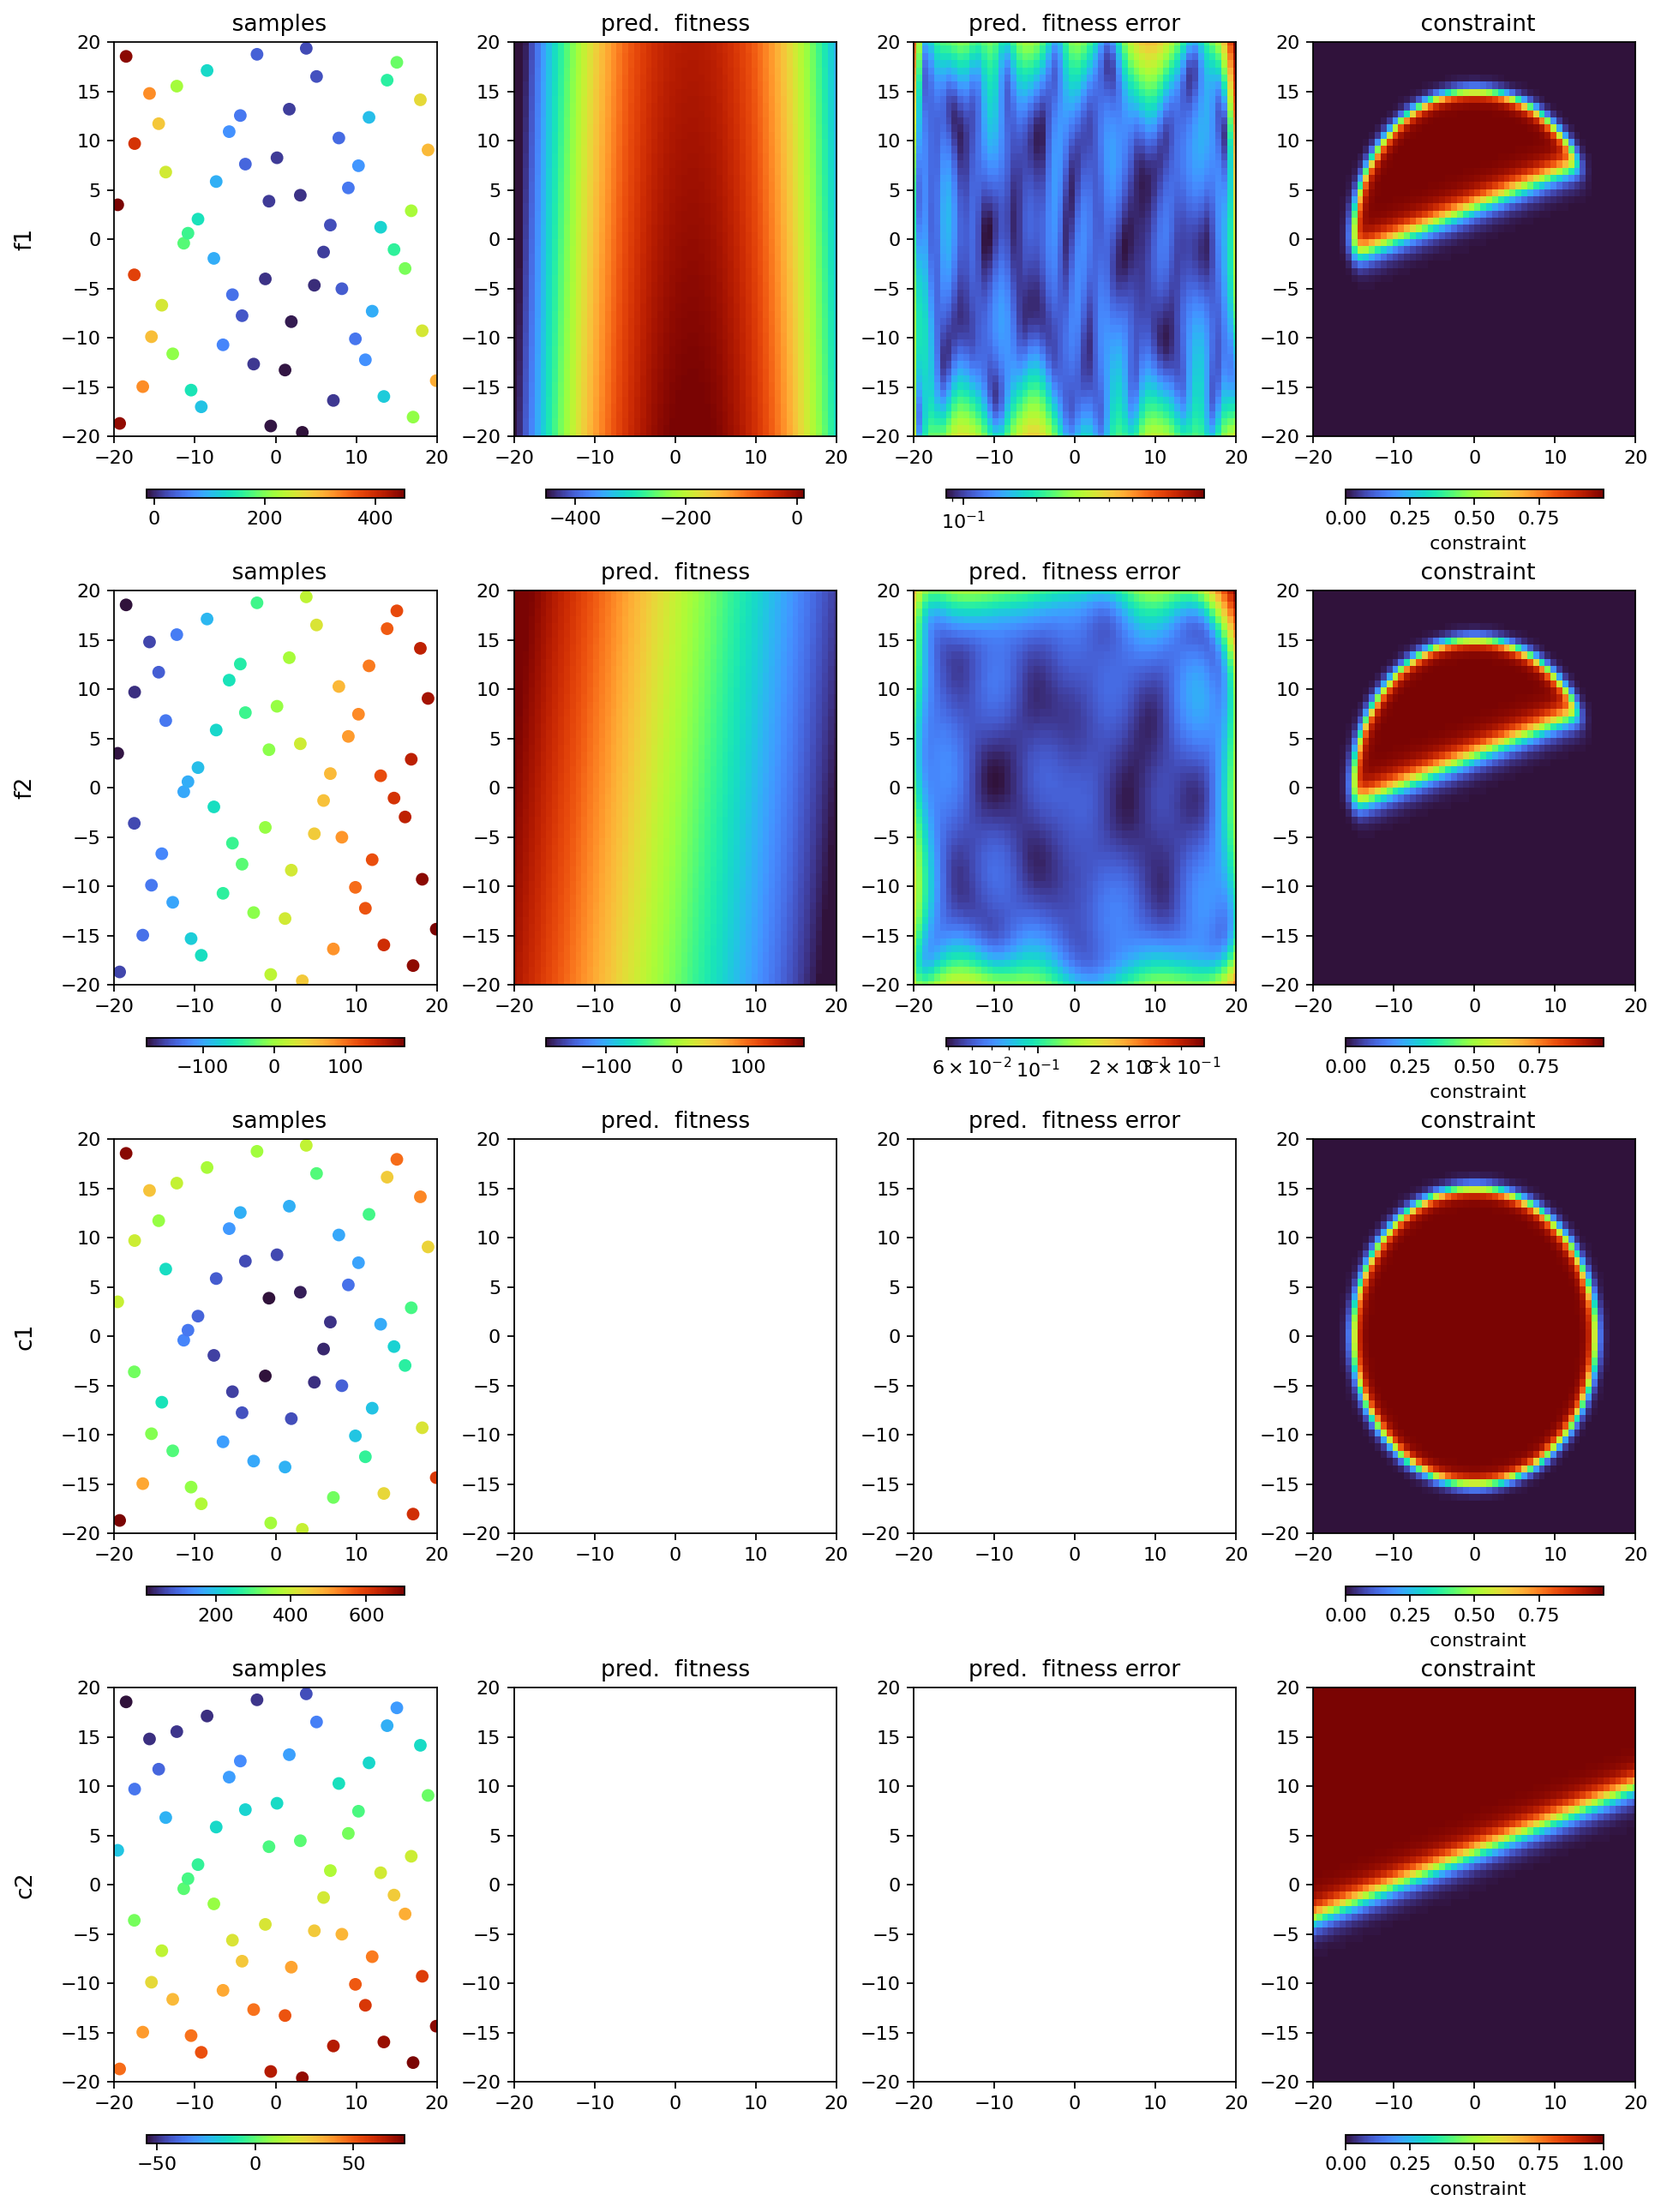

In [3]:
agent.plot_objectives()

We can plot the Pareto front (the set of all Pareto-efficient points), which shows the trade-off between the two fitnesses. The points in blue comprise the Pareto front, while the points in red are either not Pareto efficient or are invalidated by one of the constraints.

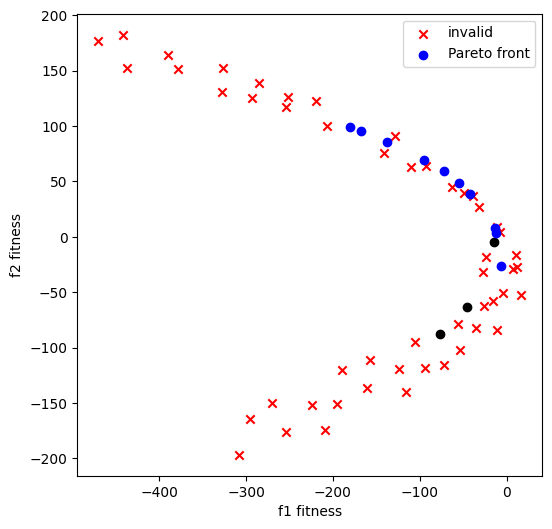

In [4]:
agent.plot_pareto_front()

We can explore the Pareto front by choosing a random point on the Pareto front and computing the expected improvement in the hypervolume of all fitness objectives with respect to that point (called the "reference point"). All this is done automatically with the `qnehvi` acquisition function:

In [5]:
# this is broken now but is fixed in the next PR
# RE(agent.learn("qnehvi", n=4))

In [ ]:
tiled_server.close()